In [2]:
import pyhepmc as hep
import os
import os
import json
import argparse
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

In [3]:
file = "tag_1_pythia8_events.hepmc"
pid = [2000015,1000015]
status = [62,1,2]
toGeV = 1

staus=[]
daughter_particles = []
events=[]




In [30]:

def end_vtx(decayvtx,pid):
    stau_decay={}
    fourvec = decayvtx.position
    products = decayvtx.particles_out
#    prod=[]
    counter=0
    for i in products:
        if abs(i.pid) in pid:
            counter+=1

    if counter >0:
#if counter>0, stau did not decay, want to keep track of it.
        for i in products:
            if abs(i.pid) not in pid:
                continue
            else:
                return end_vtx(i.end_vertex,pid)

    else:
#else counter=0, stau has decayed. record daughter particle information
#firs record decay position informatoin
        prod = []
        stau_decay["decay_lxy"]        =  fourvec.perp() 
        stau_decay["decay_x"]          =  fourvec.x 
        stau_decay["decay_y"]          =  fourvec.y 
        stau_decay["decay_z"]          =  fourvec.z 
        stau_decay["decay_t"]          =  fourvec.t
        for i in products:
            daughter_particle = {}
            daughter_mom = i.momentum
            daughter_vertex=i.production_vertex
            daughter_vector=daughter_vertex.position
#                   print("momentum of ", i, "daughter particle is", daughter_mom)
            daughter_particle["eta"] = daughter_mom.eta() 
            daughter_particle["phi"] = daughter_mom.phi() 
            daughter_particle["pt" ] = daughter_mom.pt()/toGeV 
            daughter_particle["p"  ] = daughter_mom.length()/toGeV 
            daughter_particle["x"] = daughter_vector.x
            daughter_particle["y"] = daughter_vector.y
            daughter_particle["z"] = daughter_vector.z
            daughter_particle["t"] = daughter_vector.t
            daughter_particle["status"]=i.status
            daughter_particle["pid"]=i.pid
            daughter_particle['m']=daughter_mom.m()
            prod.append(daughter_particle)
        result = [prod,stau_decay]
            

        return result



In [31]:
staus=[]
daughter_particles = []
events=[]
evt_number=0
stau_number =0
with hep.open(file) as f:
    while True:
        evt = f.read()
        evt_number+=1
        if not evt:
            break
        event ={}
        count = 0
        for particle in evt.particles:
            if abs(particle.pid) not in pid:
                continue
#            if particle.status not in status:
#                continue
            stau_number+=1
            stau ={}
            particlemom = particle.momentum
#            print('particlemom', particlemom)
            count+=1
            stau["status"]=particle.status
            stau["eta"] = particlemom.eta() 
            stau["phi"] = particlemom.phi() 
            stau["pt" ] = particlemom.pt()/toGeV 
            stau["p"  ] = particlemom.length()/toGeV 
            stau["m"  ] = particlemom.m()/toGeV 
            stau["betagamma"]  = stau["p"]/stau["m"]
            # to get the production vertex and position
            prod_vertex = particle.production_vertex
            prod_vector = prod_vertex.position
            #record prod vertex
            stau["prod_x"] = prod_vector.x
            stau["prod_y"] = prod_vector.y
            stau["prod_z"] = prod_vector.z
            stau["prod_t"] = prod_vector.t
        #if stau decays:
            decayvtx = particle.end_vertex

            if(decayvtx) :
# call the recursive function
                prods=[]
                prods,stau_decay= end_vtx(decayvtx,pid)
                
                daughter_particles.append(prods)
#                print(prods)
                #print(daughter_particles[1])
                stau.update(stau_decay)
#                print(stau)


            else:
                print("stable")
                stau["lxy"] = 99999999
                stau["decay_z"]   = 99999999
                stau["decay_t"] = 99999999 
                stau["decay_x"] =  99999999
                stau["decay_y"] = 99999999
            stau["lifetime"]= stau["decay_t"]-stau["prod_t"]
#            print(stau)
            staus.append(stau)

#unflatten
daughter_particles_unflatten = daughter_particles
print(daughter_particles_unflatten[0]) 

#flatten:
daughter_particles = [x for y in daughter_particles for x in y]



[{'eta': -0.9149584379841348, 'phi': -2.0702072464537604, 'pt': 2229.052057816547, 'p': 3229.0101113756045, 'x': -682.5730978040326, 'y': -1296.6154922512435, 'z': -1484.3120632227615, 't': 2086.492238363071, 'status': 1, 'pid': 1000049, 'm': 4.315837287515549e-05}, {'eta': -0.8466341060867019, 'phi': -2.0295665614042875, 'pt': 1283.0273497330872, 'p': 1770.98900185251, 'x': -682.5730978040326, 'y': -1296.6154922512435, 'z': -1484.3120632227615, 't': 2086.492238363071, 'status': 2, 'pid': -15, 'm': 1.7769999999586759}]


In [27]:
p = np.array([x['p'] for x in staus]) 
pt = np.array([x['pt'] for x in staus]) 
eta = np.array([x['eta'] for x in staus]) 
phi = np.array([x['phi'] for x in staus]) 
m = np.array([x['m'] for x in staus]) 
prod_x = np.array([x['prod_x'] for x in staus]) 
prod_y = np.array([x['prod_y'] for x in staus])
prod_z = np.array([x['prod_z'] for x in staus])
prod_t = np.array([x['prod_t'] for x in staus])
decay_x = np.array([x['decay_x'] for x in staus])
decay_y = np.array([x['decay_y'] for x in staus])
decay_z = np.array([x['decay_z'] for x in staus])
decay_t = np.array([x['decay_t'] for x in staus])
betagamma = np.array([x['betagamma'] for x in staus])
c = 3*10**8
lifetime = np.array([x['lifetime']/c for x in staus])
#daughter particles:
dau_p = np.array([x['p'] for x in daughter_particles]) 
dau_pt = np.array([x['pt'] for x in daughter_particles]) 
dau_eta = np.array([x['eta'] for x in daughter_particles]) 
dau_phi = np.array([x['phi'] for x in daughter_particles]) 
dau_x = np.array([x['x'] for x in daughter_particles]) 
dau_y = np.array([x['y'] for x in daughter_particles]) 
dau_z = np.array([x['z'] for x in daughter_particles]) 
dau_t = np.array([x['t'] for x in daughter_particles]) 
dau_r = np.array([np.sqrt(x['x']**2+x['y']**2) for x in daughter_particles])
dau_pid = np.array([x['pid'] for x in daughter_particles]) 
dau_status = np.array([x['status'] for x in daughter_particles]) 
status = np.array([x['status'] for x in staus]) 
dau_m = np.array([x['m'] for x in daughter_particles]) 
pt.size



47236

In [17]:
def plot2DHistogram(datax, datay, bins=100, norm="log", label=""):
    
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    #print(len(data_flatx),data_flatx)
    #print(len(data_flaty),data_flaty)
    
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)

    hh = ax.hist2d(data_flatx, data_flaty, bins=bins, norm=norm, cmap="plasma")
    
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2]  
    zlabel = "" if len(label.split(";")) < 4 else label.split(";")[3] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    
    # colorbars are annoying
    cbar = fig.colorbar(hh[3])
    #cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.set_label(zlabel, fontsize=15)

    plt.show()
def plot1DHistogram(data,bins,scale='linear',label=""):
    

    
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)
    
    ax.hist(data, bins=bins)
    
    # handle labels
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    plt.yscale(scale)
    plt.show()

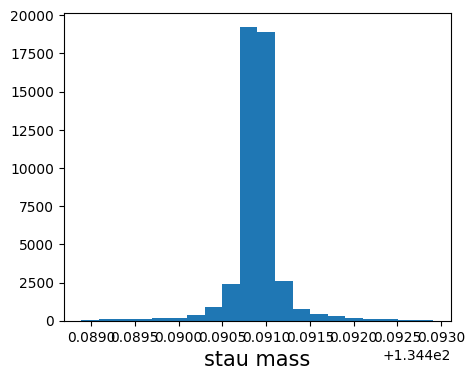

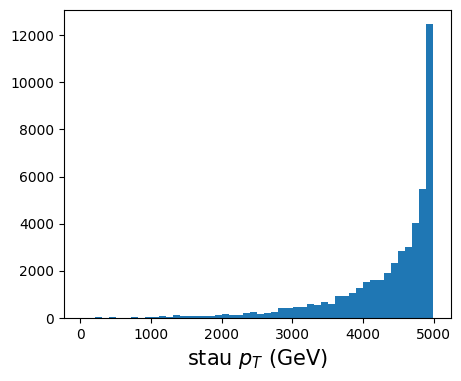

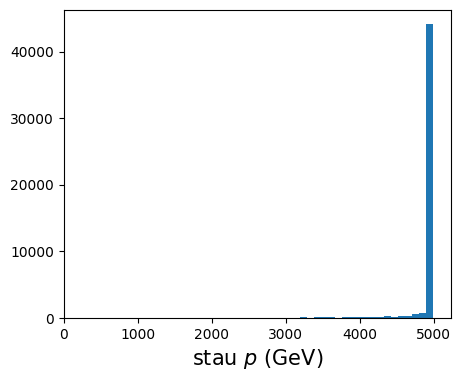

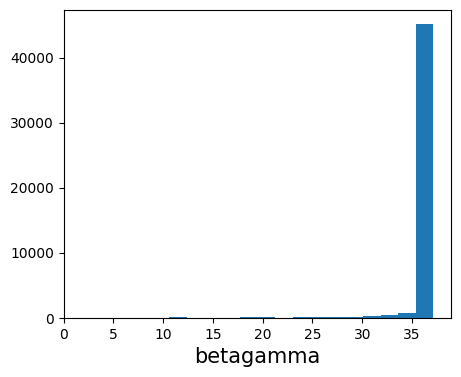

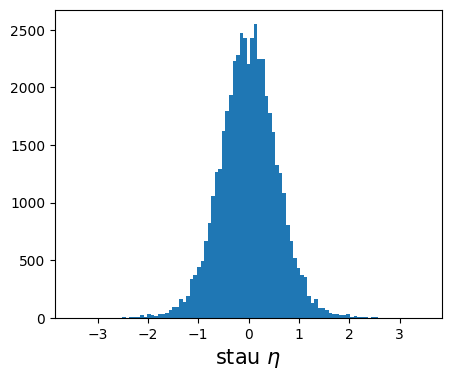

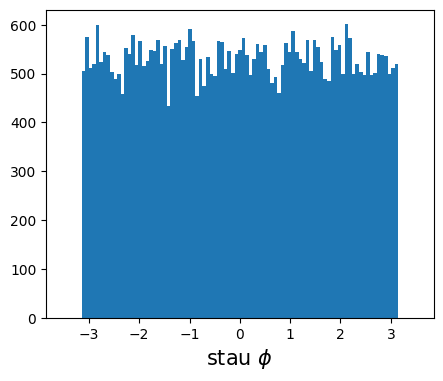

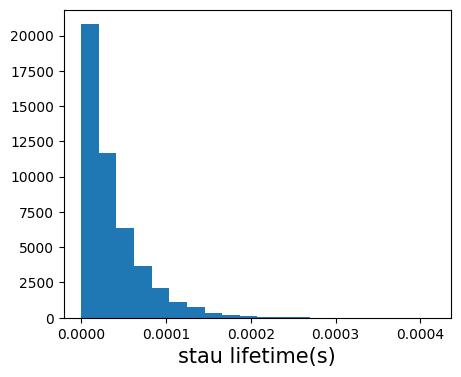

In [18]:
plot1DHistogram(m     , bins=20  , label=";stau mass")
plot1DHistogram(pt     , bins=50  , label=";stau $p_{T}$ (GeV)")
plot1DHistogram(p     , bins=50  , label=";stau $p$ (GeV)")
plot1DHistogram(betagamma, bins=20  , label=";betagamma")
plot1DHistogram(eta    , np.linspace(-3.5,3.5,100), label=";stau $\eta$")
plot1DHistogram(phi    , np.linspace(-3.5,3.5,100), label=";stau $\phi$")
plot1DHistogram(lifetime, bins=20  , label=";stau lifetime(s)")


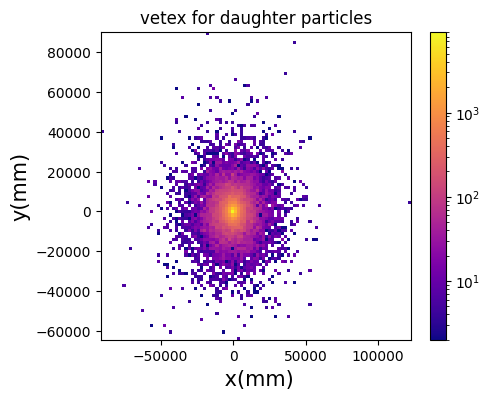

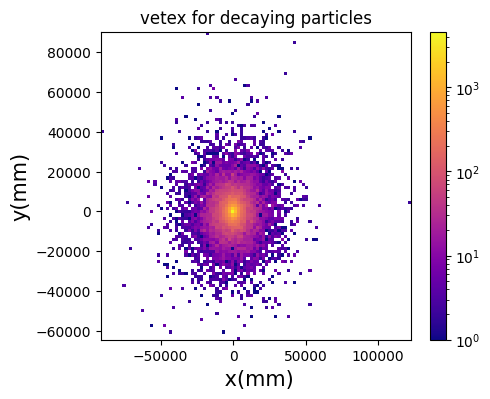

In [19]:
plot2DHistogram(dau_x,dau_y,bins=100,label ="vetex for daughter particles; x(mm);y(mm)")
plot2DHistogram(decay_x,decay_y,bins=100,label ="vetex for decaying particles; x(mm);y(mm)")



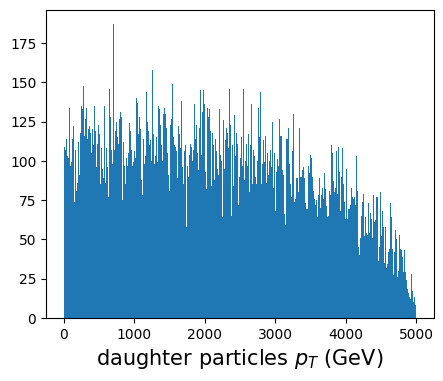

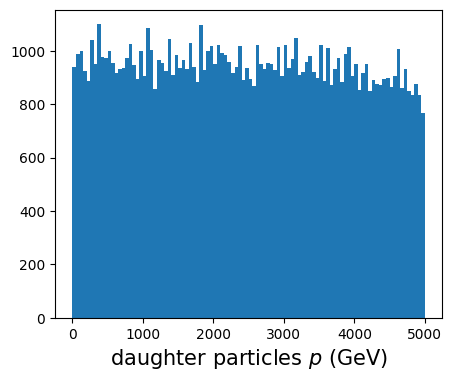

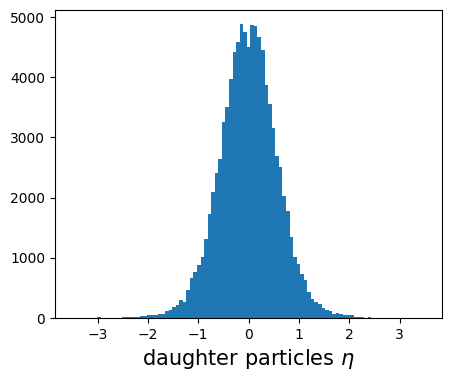

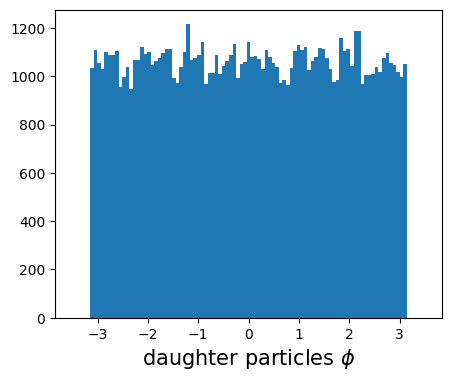

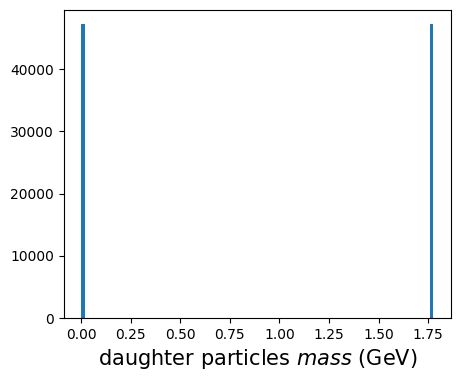

In [29]:
plot1DHistogram(dau_pt     , bins=1000  , label=";daughter particles $p_{T}$ (GeV)")
plot1DHistogram(dau_p     , bins=100  , label=";daughter particles $p$ (GeV)")
plot1DHistogram(dau_eta    , np.linspace(-3.5,3.5,100), label=";daughter particles $\eta$")
plot1DHistogram(dau_phi    , np.linspace(-3.5,3.5,100), label=";daughter particles $\phi$")
plot1DHistogram(dau_m     , bins=100  , label=";daughter particles $mass$ (GeV)")

-95.73541446091451


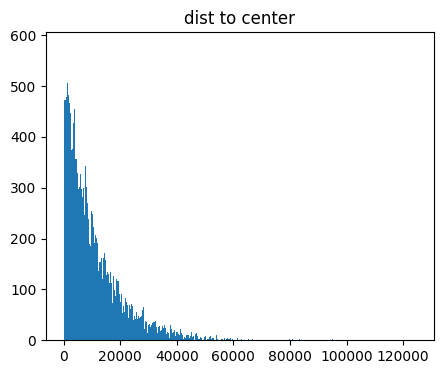

In [12]:
#check if lifetime and velocity in lab frame makes sense
v = c*np.tanh(np.arcsinh(betagamma))

dist = np.sqrt((decay_x-prod_x)**2+(decay_y-prod_y)**2+(decay_z-prod_z)**2)
vt = v*lifetime
print(min(dist-vt))
plot1DHistogram(dist    , bins=1000  , label="dist to center")

In [120]:
dau_pid

array([1000049,     -15, 1000049, ...,     -15, 1000049,      15])

(array([3.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00,
        1.6000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 7.0000e+00,
        3.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 2.2000e+01,
        2.1000e+01, 6.0000e+00, 0.0000e+00, 3.0000e+00, 3.0000e+00,
        3.0000e+01, 5.0000e+00, 5.0000e+00, 2.2000e+01, 3.0000e+00,
        8.0000e+00, 3.0000e+00, 1.4000e+01, 1.0000e+00, 0.0000e+00,
        4.0000e+00, 4.0000e+00, 4.0000e+00, 4.0000e+00, 4.0000e+00,
        1.0000e+01, 0.0000e+00, 7.0000e+00, 3.0000e+00, 2.0000e+00,
        1.1000e+01, 2.8000e+01, 0.0000e+00, 8.0000e+00, 5.0000e+00,
        1.8000e+01, 4.0000e+00, 3.0000e+00, 1.4000e+01, 9.0000e+00,
        2.0000e+00, 4.0000e+00, 1.0000e+00, 6.0000e+00, 3.0000e+00,
        0.0000e+00, 1.5000e+01, 2.8000e+01, 1.3000e+01, 9.0000e+00,
        1.9000e+01, 3.2000e+01, 1.4000e+01, 2.1000e+01, 2.4000e+01,
        2.4000e+01, 1.5000e+01, 1.6000e+01, 9.00

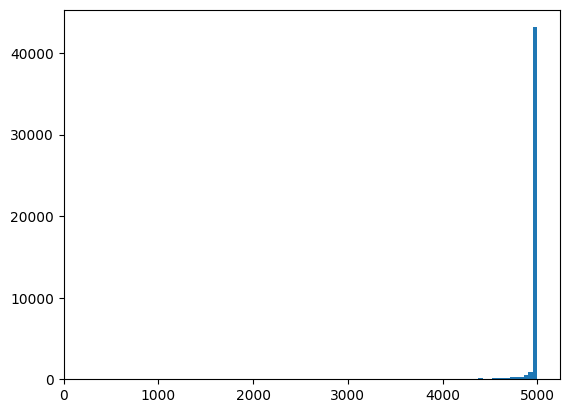

In [121]:
plt.hist(p,100)

In [28]:
for i in np.arange(0,20):
    print(i, "status:", dau_status[i],dau_pid[i],dau_pt[i],dau_m[i])

0 status: 1 1000049 2229.052057816547 4.315837287515549e-05
1 status: 2 -15 1283.0273497330872 1.7769999999586759
2 status: 1 1000049 107.5477175308272 -1.9073486328125e-06
3 status: 2 15 3403.9416383767657 1.7769999989104794
4 status: 1 1000049 2229.052057816547 4.315837287515549e-05
5 status: 2 -15 1283.0273497330872 1.7769999999586759
6 status: 1 1000049 107.5477175308272 -1.9073486328125e-06
7 status: 2 15 3403.9416383767657 1.7769999989104794
8 status: 1 1000049 3123.7053914292537 0.0
9 status: 2 -15 1720.495249210816 1.7770000000897004
10 status: 1 1000049 3811.7986089572964 0.0
11 status: 2 15 1033.015396767632 1.7770000001552126
12 status: 1 1000049 3123.7053914292537 0.0
13 status: 2 -15 1720.495249210816 1.7770000000897004
14 status: 1 1000049 3811.7986089572964 0.0
15 status: 2 15 1033.015396767632 1.7770000001552126
16 status: 23 1000049 3760.878564058761 0.0
17 status: 23 -15 1222.3845460675248 1.7770000000241881
18 status: 1 1000049 4457.182207246011 0.0
19 status: 2 15 5

In [152]:
print(status[0:20])

[22 22 51 52 22 22 52 51 22 22 22 22 51 52 22 22 52 51 51 52]


In [20]:
print(dau_x.size)

94472


47236
